# Analyze the results given by NAS

## Build the network given by NAS 

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt


#50_partitions
#optimized_parameters = [8.50071696e-04, 3.55273289e-01, 3.86577994e-01, 9.51559796e-01,
# 1.00000000e+00, 1.60000000e+01, 1.57000000e+03]
#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]
#21_partitions_tanh
#optimized_parameters = [6.70771985e-04, 3.71587509e-01, 6.03183109e-01, 8.71381868e-01,
#                        3.22005780e-01, 2.00000000e+00, 1.82000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25
by_partitions=False
partition_length=15
activation=''

if(activation):
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    
else:
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions.json'

/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/davidcalhas/anacond

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(51, 874, 6)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(102, 874, 6)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(153, 874, 6)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(204, 874, 6)
Extracting parameters from /home/davidcalhas/eeg_t

In [2]:
n_ica_components = 20

eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, 
                                                                by_partitions=by_partitions,
                                                                partition_length=partition_length, 
                                                                f_resample=f_resample,
                                                                roi=1, roi_ica_components=n_ica_components)

n_voxels = bold_train.shape[1]

n_voxels = bold_train.shape[1]
interval_length = bold_train.shape[2]

print("Finished Loading Data")


_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), 
                                                 bold_shift=bold_shift, 
                                                 n_partitions=n_partitions, 
                                                 f_resample=f_resample, 
                                                 roi=1, roi_ica_components=n_ica_components)




Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(24, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(48, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(72, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(96, 2607, 14)
Extracting parameters from /home/davidcalhas/

In [3]:
min_train = np.amin(bold_train)
min_val = np.amin(bold_val)
min_test = np.amin(bold_test)

print(min_train, min_val, min_test)

max_value = np.amin([min_train, min_val, min_test])

print(max_value)

bold_train = bold_train - max_value+0.001
bold_val = bold_val - max_value+0.001
bold_test = bold_test - max_value+0.001

-101.14161761576095 -16.10792196783093 -20.505247135200758
-101.14161761576095


In [4]:
bold_train = np.log(bold_train)
bold_val = np.log(bold_val)
bold_test = np.log(bold_test)

In [5]:
#check number of zeros
#replace zeros voxels with nearby/adjacent voxels

#for ind in bold_test:
#    for voxel in ind:
#        if(not all(x==voxel[0] for x in voxel)):
#            print(voxel)

In [6]:
print(np.amin(bold_train), np.amax(bold_train))
print(np.amin(bold_val), np.amax(bold_val))
print(np.amin(bold_test), np.amax(bold_test))

-6.907755278982137 7.617906627686802
4.443059357299147 5.923927066238223
4.389962195663428 7.109751200173943


In [7]:
print(np.amin(bold_train, axis=(0,1,2,3)))
print(np.amin(bold_val))
print(np.amin(bold_test))

-6.907755278982137
4.443059357299147
4.389962195663428


In [8]:
bold_train[50][1929][11][0] = bold_train[50][1929][12][0]

np.histogram(bold_train)

(array([      3,      19,   42992,  289521,  330032,  323646,  448283,
        1538130, 5558409,  228485]),
 array([3.60290546, 4.00440558, 4.40590569, 4.80740581, 5.20890593,
        5.61040604, 6.01190616, 6.41340628, 6.81490639, 7.21640651,
        7.61790663]))

In [9]:

#standardize data
#eeg_train, bold_train, eeg_train_scaler, bold_train_scaler = data_utils.standardize(eeg_train, bold_train)
#eeg_val, bold_val, eeg_val_scaler, bold_val_scaler = data_utils.standardize(eeg_val, bold_val)



X_train_eeg, X_train_bold, tr_y, X_bold_train_target = data_utils.create_eeg_bold_pairs(eeg_train, bold_train, instances_per_individual=n_partitions)
X_val_eeg, X_val_bold, tv_y, X_bold_val_target = data_utils.create_eeg_bold_pairs(eeg_val, bold_val, instances_per_individual=n_partitions)


tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

#eeg_test, bold_test, eeg_test_scaler, bold_test_scaler = data_utils.standardize(eeg_test, bold_test)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Pairs Created


### Train the network

In [11]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            loss_function=losses.get_reconstruction_log_cosine_voxel_loss,
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y,
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_bold_train_target=X_bold_train_target,
                                                            X_bold_val_target=X_bold_val_target)

model_name = "LComb"

train set mean:  -5.59933315316836
train set std:  0.43121544640005344
validation set mean:  -6.340628534555435
validation set std:  0.0262835622695783
test set mean:  -6.2057314348220824
test set std:  0.17065808506104826


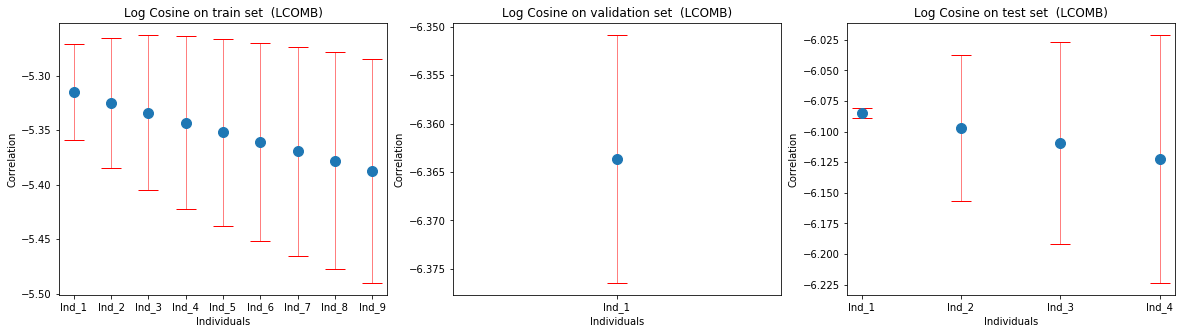

train set mean:  -10.965042702356975
train set std:  0.5932268754793526
validation set mean:  -9.86777494351069
validation set std:  0.11907182388213354
test set mean:  -9.707097949981689
test set std:  0.3238086036961053


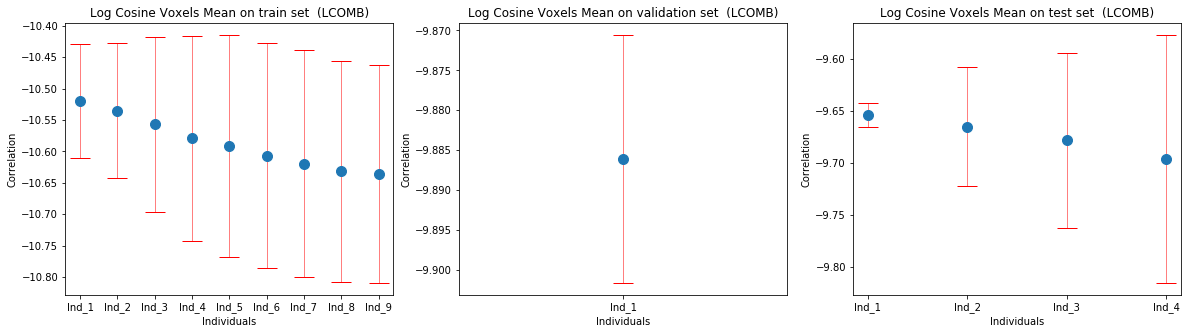

train set mean:  0.9959261844555537
train set std:  0.0018677966601231665
validation set mean:  0.9982361930112044
validation set std:  4.6406545162834996e-05
test set mean:  0.997952823638916
test set std:  0.0003445993403255442


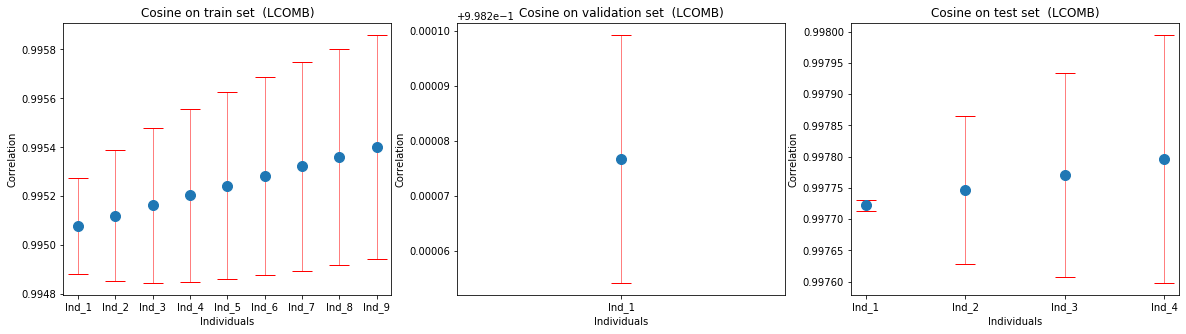

train set mean:  -0.999979633341233
train set std:  1.1222053049180116e-05
validation set mean:  -0.9999477279682955
validation set std:  8.33422615705004e-06
test set mean:  -0.9999362021684647
test set std:  1.8055547325081185e-05


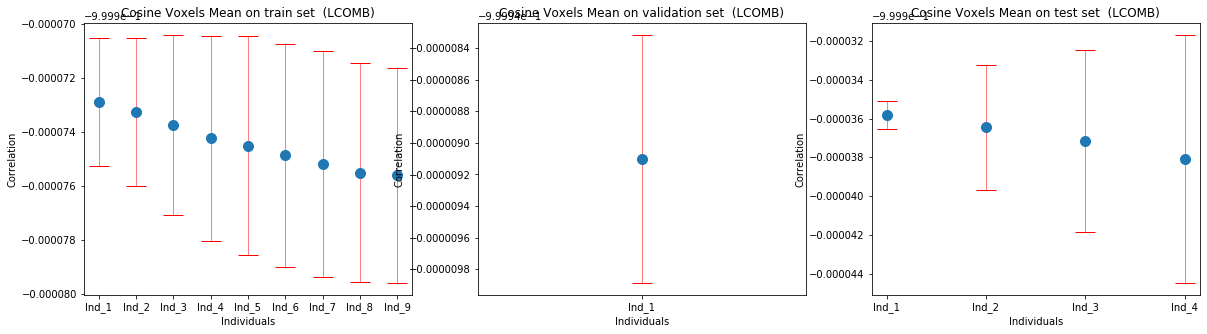

train set mean:  690.3930534362793
train set std:  28.21375980571328
validation set mean:  299.1492748260498
validation set std:  1.626671573243007
test set mean:  303.5383239746094
test set std:  8.700308687666217


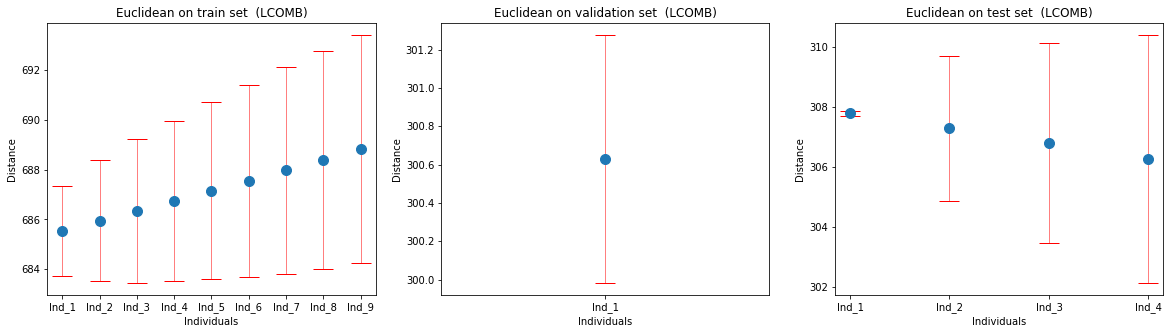

train set mean:  2583.213548787435
train set std:  105.56619838441091
validation set mean:  1119.3102925618489
validation set std:  6.087778351777894
test set mean:  1135.7314697265624
test set std:  32.556305915246604


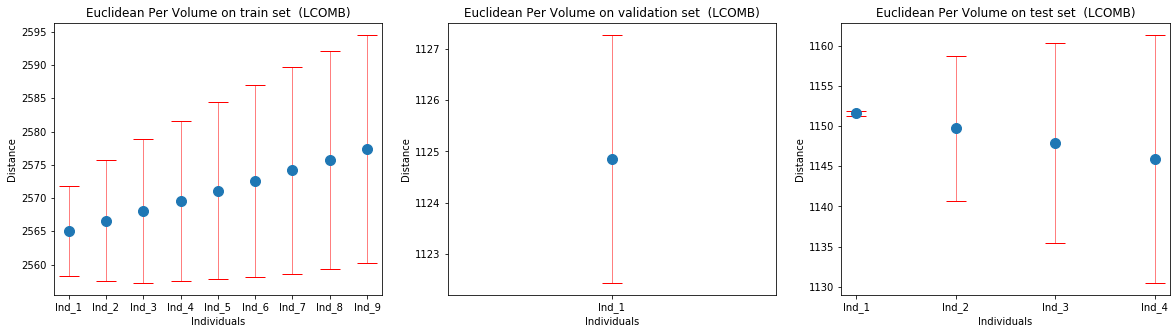

In [14]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

[5.364418029785156e-07, 5.364418029785156e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 7.152557373046875e-07, 8.344650268554688e-07, 8.344650268554688e-07, 8.344650268554688e-07, 8.344650268554688e-07, 9.5367431640625e-07, 9.5367431640625e-07, 9.5367431640625e-07, 9.5367431640625e-07, 1.0132789611816406e-06, 1.0132789611816406e-06, 1.0728836059570312e-06, 1.0728836059570312e-06, 1.0728836059570312e-06, 1.1324882507324219e-06, 1.1324882507324219e-06, 1.2516975402832031e-06, 1.2516975402832031e-06, 1.2516975402832031e-06, 1.2516975402832031e-06, 1.3709068298339844e-06, 1.3709068298339844e-06, 1.3709068298339844e-06, 1.3709068298339844e-06, 1.430511474609375e-06, 1.430511474609375e-06, 1.4901161193847656e-06, 1.4901161193847656e-06, 1.4901161193847656e-06, 1.5497207641601562e-06, 1.5497207641601562e-06, 1.5497207641601562e-06, 1.5497207641601562e-06, 1.5497207641601562e-06]


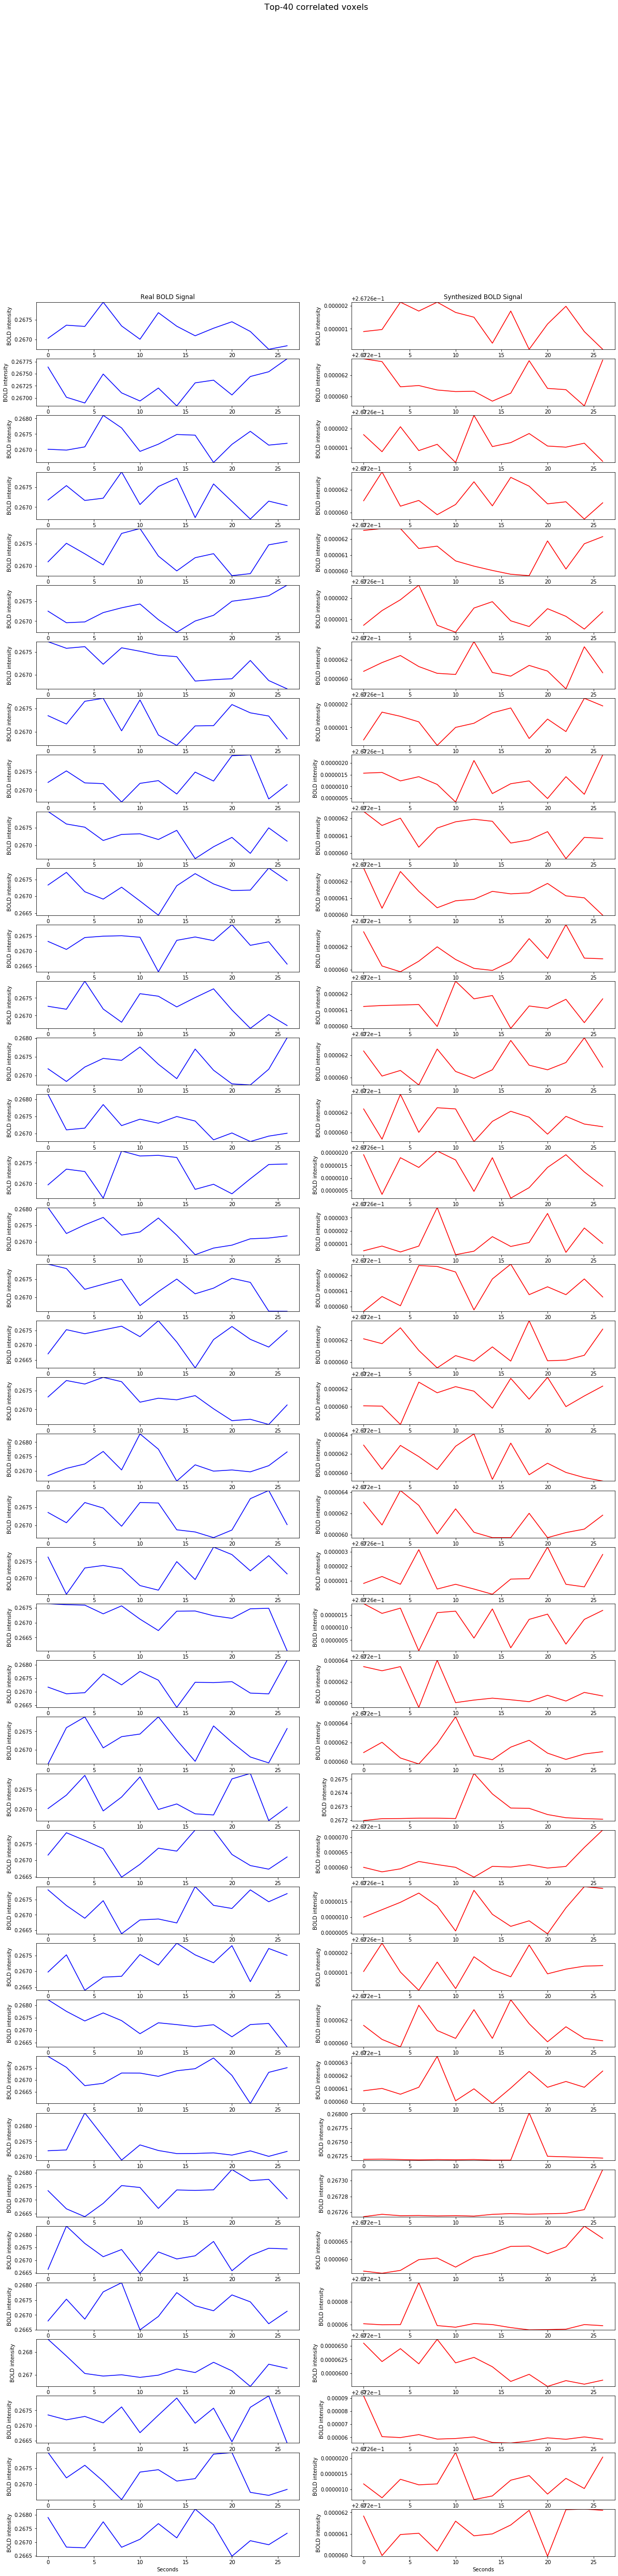

In [13]:
import importlib
importlib.reload(viz)

eeg_set = eeg_test
bold_set = bold_test

top_k = 40

#top_voxels = rank_best_synthesized_voxels(bold_set[individual], decoder_network(eeg_network(eeg_set))[individual].numpy(), top_k=top_k)

global_shape = (bold_set.shape[0]*bold_set.shape[1], bold_set.shape[2], bold_set.shape[3])
individual = None
top_voxels = viz.rank_best_synthesized_voxels(bold_set.reshape(global_shape), decoder_network(eeg_network(eeg_set)).numpy().reshape(global_shape), top_k=top_k, verbose=1)

viz._plot_voxels(bold_set.reshape(global_shape), decoder_network(eeg_network(eeg_set)).numpy().reshape(global_shape),
             individual=individual, voxels=top_voxels, normalized=True)


### Try the same hyperparameters, but in an autoencoder training process without the bold branch

In [11]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])


auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)

validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                                                    X_train_bold, 
                                                    auto_encoder_model, 
                                                    epochs=40, 
                                                    auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                    loss_function=losses.get_reconstruction_log_cosine_voxel_loss,
                                                    batch_size=batch_size, 
                                                    X_val_eeg=eeg_val, 
                                                    X_val_bold=bold_val,
                                                    eeg_train=eeg_train, 
                                                    bold_train=bold_train, 
                                                    eeg_val=eeg_val, 
                                                    bold_val=bold_val,
                                                    X_bold_train_target=X_bold_train_target,
                                                    X_bold_val_target=X_bold_val_target)

model_name = "AE"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Autoencoder Loss:  -10.178638 || Validation Autoencoder Loss:  -9.867872
Autoencoder Loss:  -10.585367 || Validation Autoencoder Loss:  -9.867749
Autoencoder Loss:  -10.585343 || Validation Autoencoder Loss:  -9.867724
Autoencoder Loss:  -10.585305 || Validation Autoencoder Loss:  -9.867873
Autoencoder Loss:  -10.585358 || Validation Autoencoder Loss:  -9.867801
Autoencoder Loss:  -10.585311 || Validation Autoencoder Loss:  -9.8677
Autoencoder Loss:  -10.585292 || Validation Autoencoder Loss:  -9.86775
Autoencoder Loss:  -10.585335 || Validation Autoencoder Loss:  -9.867799
Autoencoder Loss:  -10.58537 || Validation Autoencoder Loss:  -9.867774
Autoencoder Loss:  -10.585365 || Validation Autoencoder Loss:  -9.867679
Autoencoder Loss:  -10.585331 || Validation Autoencoder Loss:  -9.867872
Autoencoder Loss:  -10.585332 || Validation Autoencoder Loss:  -9.867676
Autoencoder Loss:  -10.585397 || V

train set mean:  -1.8623423740267753
train set std:  0.021546868332562773
validation set mean:  -1.8422568912307422
validation set std:  0.0028922392601629494
test set mean:  -1.8383319211006164
test set std:  0.01525360515951723


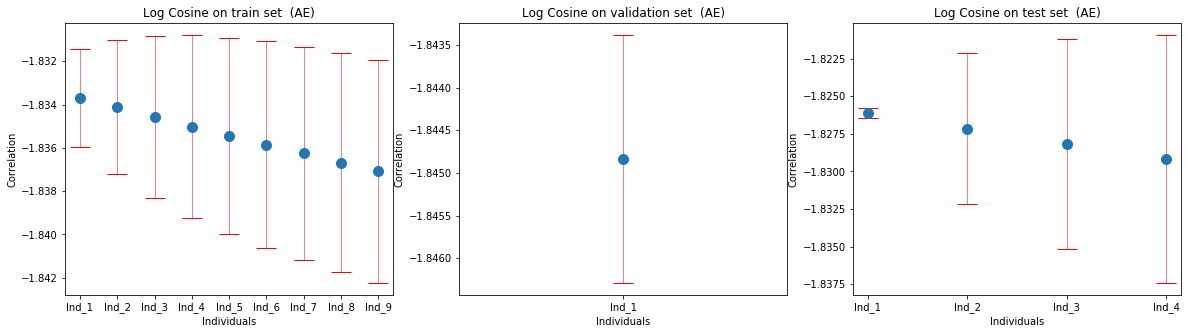

train set mean:  -10.964945995807648
train set std:  0.5930846219986544
validation set mean:  -9.86767558256785
validation set std:  0.11904189653018435
test set mean:  -9.707075128555298
test set std:  0.32394926891962


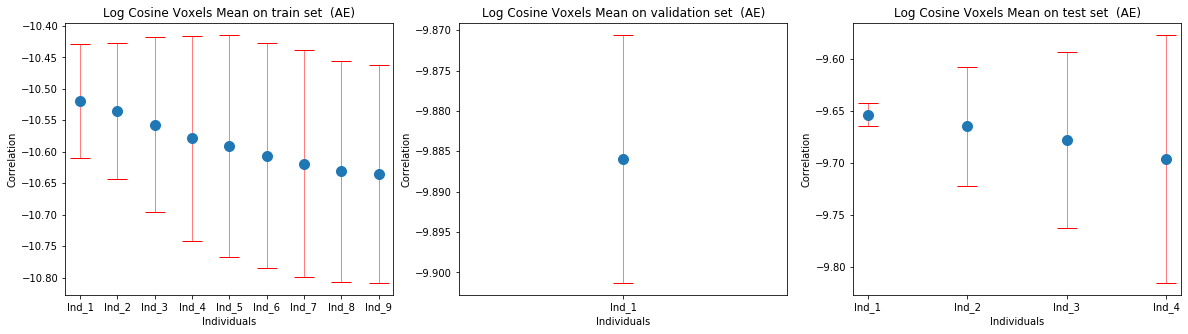

train set mean:  0.8446554854512215
train set std:  0.003352807250329785
validation set mean:  0.8415399442116419
validation set std:  0.00045829227072303666
test set mean:  0.8408989250659943
test set std:  0.0024266773993135223


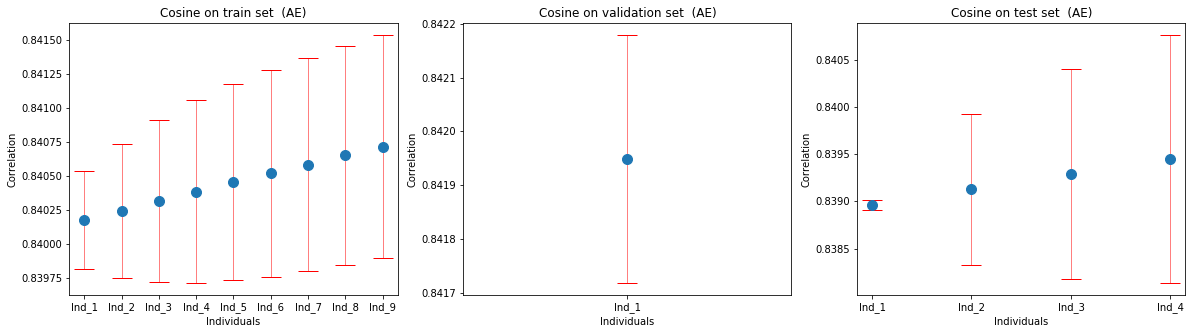

train set mean:  -0.9999796323478222
train set std:  1.1222409441476775e-05
validation set mean:  -0.999947735418876
validation set std:  8.33558925340181e-06
test set mean:  -0.9999361884593964
test set std:  1.8063254579298102e-05


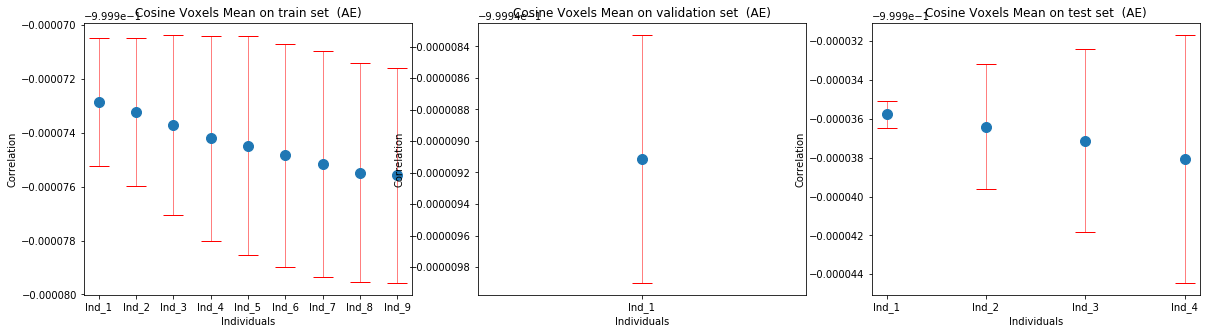

train set mean:  42756.773046875
train set std:  23.640954958135698
validation set mean:  43086.406494140625
validation set std:  1.775529817525063
test set mean:  43082.99296875
test set std:  5.103673113361286


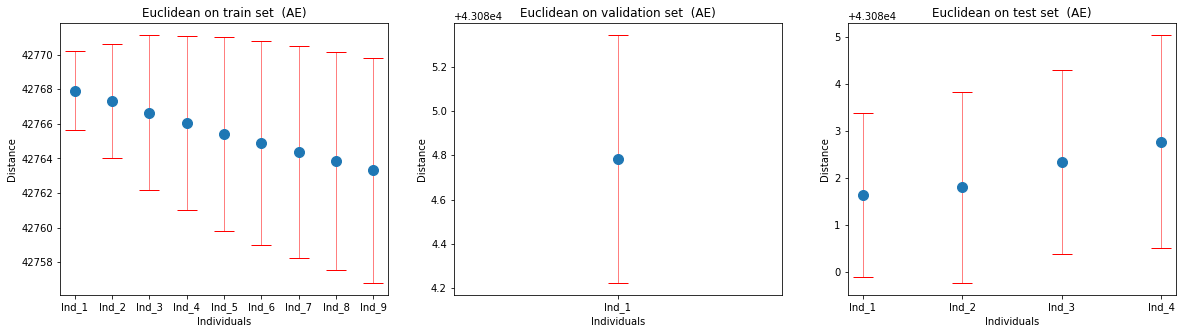

train set mean:  159981.195703125
train set std:  88.45603649097734
validation set mean:  161214.572265625
validation set std:  6.642861621657902
test set mean:  161201.79828125
test set std:  19.096501961946252


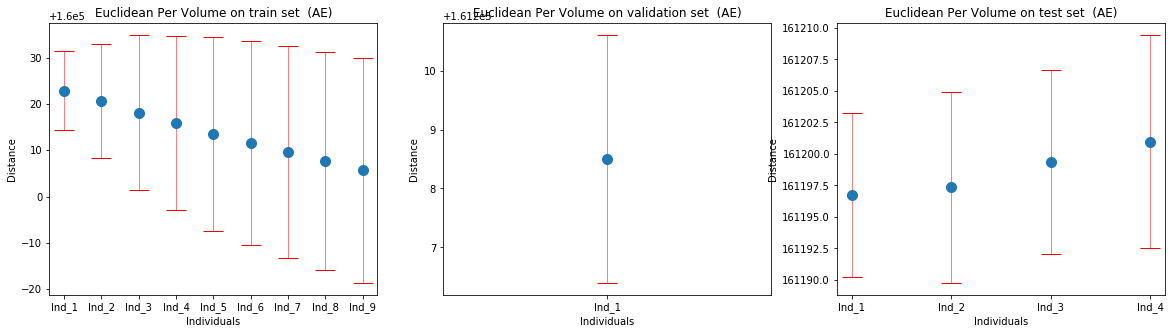

In [12]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an adversarial training process

In [ ]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=40, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       g_loss_function=losses.loss_minmax_generator,
                                                       d_loss_function=losses.loss_minmax_discriminator,
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y,
                                                       eeg_train=eeg_train, 
                                                       bold_train=bold_train, 
                                                       eeg_val=eeg_val, 
                                                       bold_val=bold_val,
                                                       X_bold_train_target=X_bold_train_target,
                                                       X_bold_val_target=X_bold_val_target)

model_name = "GAN"

GAN Encoder Loss:  0.28224474  || GAN Decoder Loss:  1.4172822  || GAN Validation Decoder Loss:  -0.090141736  || Train Reconstruction Loss:  -0.07111931  || Validation Reconstruction Loss:  -0.090141736
GAN Encoder Loss:  1.864723  || GAN Decoder Loss:  0.14227489  || GAN Validation Decoder Loss:  -0.42142236  || Train Reconstruction Loss:  -0.2885224  || Validation Reconstruction Loss:  -0.42142236
GAN Encoder Loss:  1.9446843  || GAN Decoder Loss:  0.2333924  || GAN Validation Decoder Loss:  -0.054227676  || Train Reconstruction Loss:  -0.06225557  || Validation Reconstruction Loss:  -0.05422768
GAN Encoder Loss:  2.9893746  || GAN Decoder Loss:  0.007814215  || GAN Validation Decoder Loss:  -0.07879609  || Train Reconstruction Loss:  -0.08364038  || Validation Reconstruction Loss:  -0.078796096
GAN Encoder Loss:  2.6987917  || GAN Decoder Loss:  0.010363631  || GAN Validation Decoder Loss:  -0.087482736  || Train Reconstruction Loss:  -0.091318995  || Validation Reconstruction Loss

In [ ]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try to check if alternate training between LComb and GAN training

In [30]:
#eeg_network, bold_network, decoder_network = get_models_and_shapes()

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=5, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

Encoder Loss:  0.118197516  || Decoder Loss:  -0.10892728 Validation Decoder Loss:  -0.34396172
Encoder Loss:  0.17350961  || Decoder Loss:  -0.21215793 Validation Decoder Loss:  -0.417525
Encoder Loss:  0.17483221  || Decoder Loss:  -0.21957809 Validation Decoder Loss:  -0.42274988
Encoder Loss:  0.17368379  || Decoder Loss:  -0.22170837 Validation Decoder Loss:  -0.42290154
Encoder Loss:  0.17259873  || Decoder Loss:  -0.22295734 Validation Decoder Loss:  -0.42123955
GAN Encoder Loss:  1.0127182  || GAN Decoder Loss:  0.14818361  || GAN Validation Decoder Loss:  -0.7285427  || Train Reconstruction Loss:  0.083577104  || Validation Reconstruction Loss:  0.5169993
GAN Encoder Loss:  0.5068348  || GAN Decoder Loss:  0.5557646  || GAN Validation Decoder Loss:  -0.36623427  || Train Reconstruction Loss:  0.12438231  || Validation Reconstruction Loss:  0.30665627
GAN Encoder Loss:  0.24195859  || GAN Decoder Loss:  1.0542921  || GAN Validation Decoder Loss:  -0.2962604  || Train Reconstruc

train set mean:  -0.13035505447935844
train set std:  0.10439693812962365
validation set mean:  -0.2702327285494123
validation set std:  0.007279591704164774
test set mean:  -0.2692250900325321
test set std:  0.013276322805917784


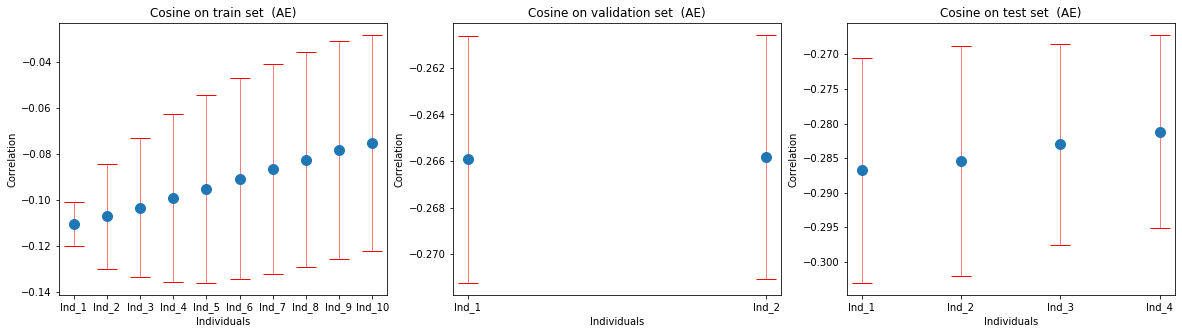

train set mean:  217.21822008405414
train set std:  33.241409173264245
validation set mean:  1998.391369047619
validation set std:  2.57665969646488
test set mean:  1995.119361514137
test set std:  6.124074982564129


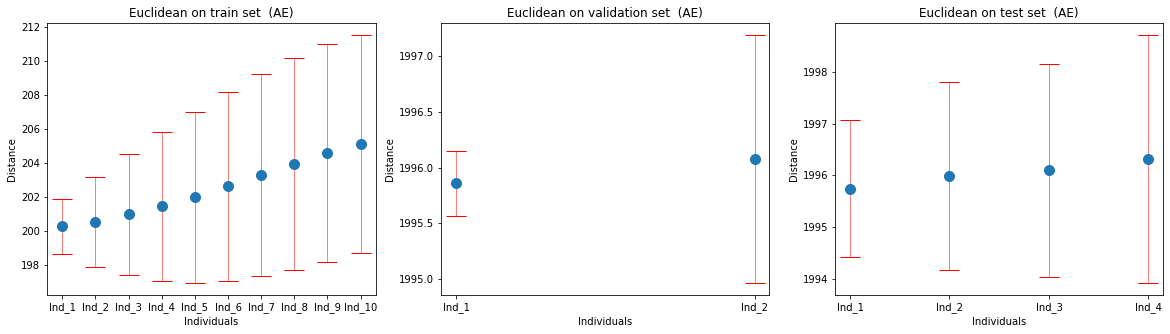

In [31]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Top-K ranking synthesis

In [10]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.ranked_synthesis_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            bold_network=bold_network, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            loss_function=losses.get_reconstruction_log_cosine_loss,
                                                            batch_size=batch_size, 
                                                            top_k=5, 
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Conv2D: Dst tensor is not initialized. [Op:Conv2D]